In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from datetime import datetime
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from dataset import DataSet
import model

In [2]:
flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_string('coarse_checkpoint',
                    '/home/rayner/tensorflow/models/inception/cnn_depth_tensorflow/230617/coarse/',
                    'coarse model checkpoint')
flags.DEFINE_string('refine_checkpoint',
                    '/home/rayner/tensorflow/models/inception/cnn_depth_tensorflow/230617/refine/',
                    'refine model checkpoint')
flags.DEFINE_integer('batch_size', 8, 'Batch size')
flags.DEFINE_string('train_file', 'train.csv', 'Train file')

In [31]:
with tf.Graph().as_default():
    global_step = tf.Variable(0, trainable=False)
    dataset = DataSet(FLAGS.batch_size)
    images, depths, invalid_depths = dataset.csv_inputs(FLAGS.train_file)
    keep_conv = tf.placeholder(tf.float32)
    keep_hidden = tf.placeholder(tf.float32)
    coarse = model.inference(images, keep_conv, trainable=False)
    logits = model.inference_refine(images, coarse, keep_conv,
                                    keep_hidden, trainable=False)
    
    loss = model.loss(coarse, depths, invalid_depths)
#     train_op = op.train(loss, global_step, FLAGS.batch_size)
#     init_op = tf.initialize_all_variables()
    
    sess = tf.Session(config=tf.ConfigProto(
                          log_device_placement=True,
                          gpu_options=tf.GPUOptions(visible_device_list='1')
                      ))
    
#     sess.run(init_op)
    tf.global_variables_initializer()
    
    # parameters
    coarse_params = {}
    refine_params = {}

    for variable in tf.trainable_variables():
        variable_name = variable.name
        print("parameter: %s" % (variable_name))
        if variable_name.find("/") < 0 or variable_name.count("/") != 1:
            continue
        if variable_name.find('coarse') >= 0:
            coarse_params[variable_name] = variable
        if variable_name.find('fine') >= 0:
            refine_params[variable_name] = variable
    # define saver
#     print(coarse_params, refine_params)
    saver_coarse = tf.train.Saver(coarse_params)
    saver_refine = tf.train.Saver(refine_params)
    
    # fine tune
    coarse_ckpt = tf.train.get_checkpoint_state(FLAGS.coarse_checkpoint)
    if coarse_ckpt and coarse_ckpt.model_checkpoint_path:
        print("Restoring pretrained coarse model...")
        saver_coarse.restore(sess, coarse_ckpt.model_checkpoint_path)
        print("Pretrained coarse model restored.")
    else:
        print("No Pretrained coarse model.")

    refine_ckpt = tf.train.get_checkpoint_state(FLAGS.refine_checkpoint)
    if refine_ckpt and refine_ckpt.model_checkpoint_path:
        print("Restoring pretrained refine model...")
        saver_refine.restore(sess,
                             refine_ckpt.model_checkpoint_path)
        print("Pretrained refine model restored.")
    else:
        print("No Pretrained refine model.")
        
    # predict
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    loss_value, logits_val, images_val = sess.run([loss, logits, images],
                                                  feed_dict={keep_conv: 0.8, keep_hidden: 0.5})
    
    print("%s: loss %f" % (datetime.now(), loss_value))
    
#     print (logits_val, images_val)
    
    coord.request_stop()
    coord.join(threads)
#     sess.close()

parameter: coarse1/weights:0
parameter: coarse1/biases:0
parameter: coarse2/weights:0
parameter: coarse2/biases:0
parameter: coarse3/weights:0
parameter: coarse3/biases:0
parameter: coarse4/weights:0
parameter: coarse4/biases:0
parameter: coarse5/weights:0
parameter: coarse5/biases:0
parameter: coarse6/weights:0
parameter: coarse6/biases:0
parameter: coarse7/weights:0
parameter: coarse7/biases:0
parameter: fine1/weights:0
parameter: fine1/biases:0
parameter: fine3/weights:0
parameter: fine3/biases:0
parameter: fine4/weights:0
parameter: fine4/biases:0
Restoring pretrained coarse model...
Pretrained coarse model restored.
Restoring pretrained refine model...
Pretrained refine model restored.
2017-06-28 16:40:59.700891: loss 14.385515


In [29]:
print(refine_ckpt)

model_checkpoint_path: "/home/rayner/tensorflow/models/inception/cnn_depth_tensorflow/230617/refine/model.ckpt-105"
all_model_checkpoint_paths: "/home/rayner/tensorflow/models/inception/cnn_depth_tensorflow/230617/refine/model.ckpt-85"
all_model_checkpoint_paths: "/home/rayner/tensorflow/models/inception/cnn_depth_tensorflow/230617/refine/model.ckpt-90"
all_model_checkpoint_paths: "/home/rayner/tensorflow/models/inception/cnn_depth_tensorflow/230617/refine/model.ckpt-95"
all_model_checkpoint_paths: "/home/rayner/tensorflow/models/inception/cnn_depth_tensorflow/230617/refine/model.ckpt-100"
all_model_checkpoint_paths: "/home/rayner/tensorflow/models/inception/cnn_depth_tensorflow/230617/refine/model.ckpt-105"



In [10]:
print(logits_val[0,:,:,0].shape)

(55, 74)


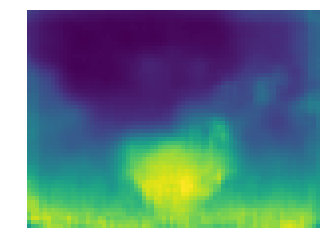

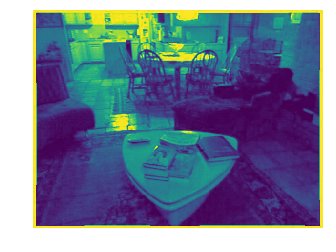

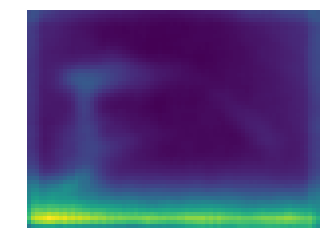

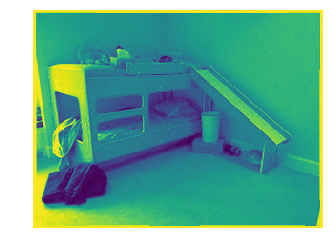

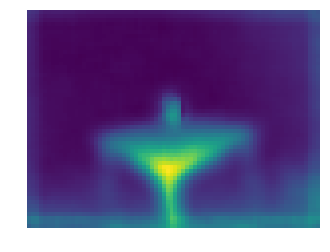

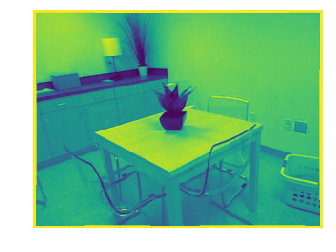

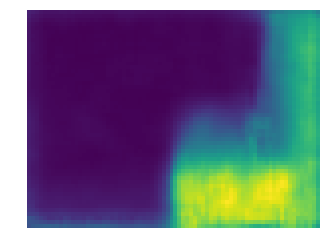

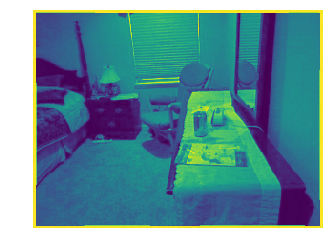

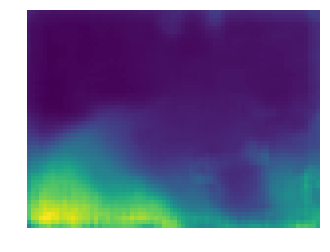

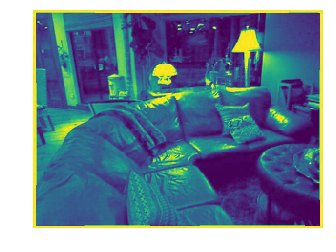

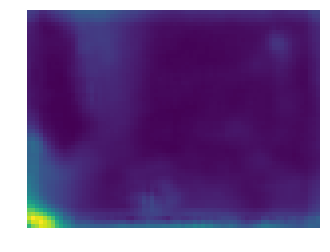

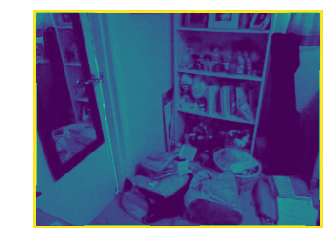

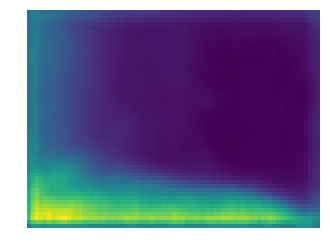

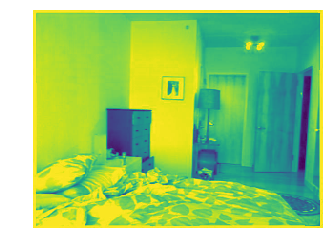

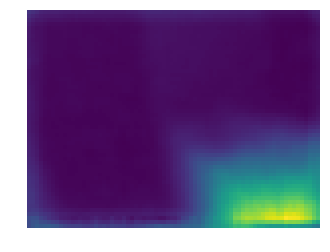

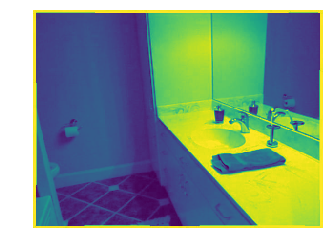

In [32]:
for i in range(8):
    plt.figure()
    plt.imshow(logits_val[i,:,:,0])
    plt.axis('off')
    plt.show()

    plt.figure()
    plt.imshow(images_val[i,:,:,0])
    plt.axis('off')
    plt.show()